### 8. Finally counting experts in news and saving them to files

In [1]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from translitua import translit
from categories_names import cat_dict

In [2]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [3]:
fix_dict = json.load(open('fix_dict.json'))

In [20]:
# Load two previous months
prev_month1_path = '../data/april.csv'
prev_month2_path = '../data/march.csv'
usecols = ['datetime', 'mycategory', 'domain_alias', 'found_names_str']

prev1 = pd.read_csv(prev_month1_path, usecols=usecols)
prev1['datetime'] = pd.to_datetime(prev1.datetime, utc=True).dt.tz_convert('Europe/Kiev')

prev2 = pd.read_csv(prev_month2_path, usecols=usecols)
prev2['datetime'] = pd.to_datetime(prev2.datetime, utc=True).dt.tz_convert('Europe/Kiev')

prev_news = pd.concat([prev1, prev2])
del prev1, prev2
prev_news.shape

(322647, 4)

In [4]:
# load last month
news_filepath = '../data/may.csv'
news = pd.read_csv(news_filepath, index_col=[0])
news['datetime'] = pd.to_datetime(news.datetime, utc=True).dt.tz_convert('Europe/Kiev')
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151053 entries, 2075213 to 2072557
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype                      
---  ------              --------------   -----                      
 0   title               151052 non-null  object                     
 1   text                151037 non-null  object                     
 2   subtitle            80390 non-null   object                     
 3   link                151053 non-null  object                     
 4   domain              151053 non-null  object                     
 5   datetime            151053 non-null  datetime64[ns, Europe/Kiev]
 6   views               61225 non-null   float64                    
 7   created_at          151053 non-null  object                     
 8   category            114894 non-null  object                     
 9   language            151053 non-null  object                     
 10  domain_alias        151053 non-null  

#### Fix Олександр Данилюк mentions

In [33]:
prev_news[prev_news.text.str.contains(r'.лександр\* Данилюк', na=False)].shape
#           &(~news.text.str.contains(r'лександр\w* Дан.люк', na=False))].text.iloc[2]


AttributeError: 'DataFrame' object has no attribute 'text'

In [157]:
part = news[news.found_names_str.str.contains(r'Олександр Даніл', na=False)&(news.text.str.contains(r'лександр\w* Данилюк', na=False))].copy()
part.shape

(75, 19)

In [158]:
part.found_names_str = part.found_names_str.str.replace('Олександр Даніл', 'Олександр Данилюк')

In [197]:
news.found_names_str.update(part.found_names_str)

In [168]:
part = news[news.found_names_str.str.contains(r'Олександр Данилюк', na=False)&(~news.text.str.contains(r'(Р|С)НБО', na=False))&(~news.text.str.contains(r'м.н.стр\w* ф.нанс', na=False))&(~news.text.str.contains(r'аціональної безпеки і оборони', na=False))].copy()


In [196]:
part.found_names_str = part.found_names_str.str.replace('Олександр Данилюк', 'Олександр Данилюк інший')

In [99]:
part.found_names_str = part.found_names_str.str.replace('§Олександр Данилюк', '')
news.found_names_str.update(part.found_names_str)

In [46]:
names_dict.loc['Олександр Данилюк', 'all_vars_str'] = 'Александр Данилюк'
names_dict.loc['Олександр Данилюк', 'stem_name'] = 'Олександр Данилюк'
names_dict.loc['Олександр Данилюк', 'num'] = 30

In [47]:
names_dict.loc['Олександр Даніл', 'all_vars_str'] = 'Олександр Данил§Александр Данил'

In [ ]:
Олександр Данилюк - Колишній міністр фінансів, голова РНБО в 2019
Олександр Данилюк - керівник експертної групи з питань надання екстреної медичної допомоги департаменту медпослуг Міністерства охорони здоров'я
Олександр Данилюк - Радник міністра оборони України Валерія Гелетея в 2014

#### Load name counts dict and file with ids

In [19]:
names_dict = pd.read_csv('joined_names_dict.csv', index_col=0)
experts_id = pd.read_csv('names_and_ids.csv', index_col=0)

In [54]:
# add name to file with ids
# n = 'Олександр Данилюк'
# experts_id.loc[n, 'id'] = experts_id.id.max()+1
# experts_id.to_csv('names_and_ids.csv')

In [6]:
def fix_names_in_list(names_list, fix_dict):
    if isinstance(names_list, list):
        return [fix_dict.get(k, k) for k in names_list]
    return None

def fix_by_name_part(names_list, name_part='Саакашв', new_name='Михайл Саакашвіл'):
    if isinstance(names_list, list):
        return [new_name if name_part in k else k for k in names_list]
    return None

In [10]:
def fix_names(df, fix_dict):
    df['found_names_checked'] = df.found_names_str.str.split('§')
    df.found_names_checked = df.found_names_checked.apply(lambda x: fix_names_in_list(x, fix_dict))
    df['found_names_str'] = df.found_names_checked.str.join('§')
    return df

In [11]:
news = fix_names(news, fix_dict)
prev_news = fix_names(prev_news, fix_dict)

In [146]:
# news[['title', 'text', 'subtitle', 'link', 'domain', 'datetime', 'views',
#        'created_at', 'category', 'language', 'domain_alias', 'mycategory',
#        'found_names_str']].to_csv(news_filepath)

#### Load files with names to delete and names to save

In [12]:
del_dict1 = json.load(open('del_list.txt'))
del_list1 = list(del_dict1.keys())

del_list_joined = list(set(del_list1))

endings_dict = json.load(open('names_with_endings.txt'))

In [13]:
top_categories = list(news.mycategory.value_counts().index[:5])
if 'Шоу-бізнес' in top_categories:
    top_categories.remove('Шоу-бізнес')
    top_categories.append(news.mycategory.value_counts().index[5])
top_str = '|'.join(top_categories)
print(top_categories)

['Інциденти', 'Політика', 'Світ', 'Економіка', 'Закордонна політика']


In [ ]:
# Євген Шевченко - активіст, колишній детектив НАБУ
# Євген Шевченко - депутат СН

In [14]:
def count_mentions(names_list, domain, category, news_date, columns_list, res_dict):
    if isinstance(names_list, list):
        for name in names_list:
            if name not in res_dict.keys():
                res_dict[name] = [0]*(len(columns_list)+1)
            res_dict[name][columns_list.index(domain)] += 1
            
            try:
                res_dict[name][columns_list.index(category)] += 1
            except:
                pass
            
            try:
                res_dict[name][columns_list.index(news_date.month_name())] += 1
            except:
                pass
            
            res_dict[name][-1] += 1

            
def count_mentions_short(names_list, res_dict):
    if isinstance(names_list, list):
        for name in names_list:
            res_dict[name] = res_dict.get(name, 0) + 1 

In [15]:
def get_image_name(name):
    if name:
        split_name = translit(name).lower().split()
        if len(split_name) == 2:
            return '_'.join([split_name[0][0], split_name[1]])
        elif len(split_name) == 1:
            return split_name[0]
    return None

In [16]:
def from_dict_to_df(ment_dict, columns_dict, del_list, endings_dict, ids, multiindex):
    if multiindex:
        tuples = []
        for key, values in columns_dict.items():
            tuples += [(key, v) for v in values] 
        tuples += [('num', '')]

        columns = pd.MultiIndex.from_tuples(tuples)
        
    else:
        columns = []
        for v in columns_dict.values():
            columns += v
        columns.append('num')

    res_df = pd.DataFrame.from_dict(ment_dict, orient='index', columns=columns)
    res_df['del_flag'] = False
    res_df['del_flag'] = res_df.del_flag.mask(res_df.index.isin(del_list), True)
    res_df = res_df.sort_values(by='num', ascending=False)
    
    res_df['expert'] = None
    
    for k,v in endings_dict.items():
        if k in res_df.index.values:
            res_df.loc[k, 'expert'] = v[0]
    
    res_df['expert_id'] = None
    res_df['expert_id'] = ids.astype('Int64')
    res_df['image_name'] = res_df['expert'].apply(get_image_name)
        
    return res_df

In [17]:
def get_mentions_dataframe(news_df, split_by, del_list, endings_dict, ids, multiindex, mentions_dict):
    columns_to_include = []
    columns_dict = {}
    if 'domain' in split_by:
        dmn = sorted(list(news_df.domain_alias.unique()))
        columns_dict['domain'] = dmn
        columns_to_include += dmn
        
    if 'category' in split_by:
        ctgr = sorted(list(news_df.mycategory.unique()))
        columns_dict['category'] = ctgr
        columns_to_include += ctgr
        
    if 'month' in split_by:
        mnth = list(news_df.datetime.dt.month_name().unique())
        columns_dict['month'] = mnth
        columns_to_include += mnth
    
    if not mentions_dict: 
        mentions_dict = {}
        news_df.apply(lambda row: 
                       count_mentions(row.found_names_checked, row.domain_alias, row.mycategory, row.datetime, columns_to_include, mentions_dict), axis=1)
    
    mentf_df = from_dict_to_df(mentions_dict, columns_dict, del_list, endings_dict, ids, multiindex)
    return mentf_df.sort_values(by='num', ascending=False), mentions_dict


In [91]:
prev_df, prev_ments_dict = get_mentions_dataframe(prev_news, 
                                ['domain', 'category'],
                                del_list_joined,
                                endings_dict,
                               experts_id['id'],
                               True, 
                               None)

In [20]:
top_news = news[news.mycategory.isin(top_categories)]
all_ments_df, all_ments_dict = get_mentions_dataframe(top_news, 
                                ['domain'],
                                del_list_joined,
                                endings_dict,
                               experts_id['id'],
                               False, 
                               None)

In [138]:
by_cat_df = {}
for cat in top_categories:
    by_cat_df[cat], _ = get_mentions_dataframe(news[news.mycategory==cat], 
                                ['domain'],
                                del_list_joined,
                                endings_dict,
                               experts_id['id'],
                               False, 
                               None)

In [6]:
def check_news_by_mention(name, column_name, ind):
    pat = rf'§{name}§|^{name}§|§{name}$|^{name}$'
#     print(news[news[column_name].str.contains(pat, na=False)].index.iloc[ind])
    print(news[news[column_name].str.contains(pat, na=False)].text.iloc[ind])

In [318]:
all_ments_df[all_ments_df.num>19].num.describe()

count     452.000000
mean      107.429204
std       299.570619
min        20.000000
25%        26.750000
50%        43.000000
75%        79.250000
max      4464.000000
Name: num, dtype: float64

### Saving to file

In [93]:
all_ments_df['prev'] = prev_df['num']
all_ments_df['prev'].fillna(0, inplace=True)

In [94]:
cols = ['expert_id', 'image_name', 'expert'] + list(all_ments_df.columns[:-6])
header = ['expert_id', 'image_name', 'name'] + list(all_ments_df.columns[:-6])

In [105]:
all_ments_df[~all_ments_df.del_flag&(all_ments_df.num>19)&(((all_ments_df.prev)/2)>=20)].sort_values(by=['num', 'expert'], ascending=[False, True]).head(30)[['expert_id', 'image_name', 'expert']]



,expert_id,image_name,expert
Юр Бутус,43,y_butusov,Юрій Бутусов
Олег Пендзин,134,o_pendzyn,Олег Пендзин
Русла Бортник,136,r_bortnyk,Руслан Бортник
Юр Романенк,564,y_romanenko,Юрій Романенко
Олекс Кущ,214,o_kushch,Олексій Кущ
Русла Бизя,166,r_biziaiev,Руслан Бізяєв
Володимир Фесенк,230,v_fesenko,Володимир Фесенко
Дмитр Гордон,111,d_hordon,Дмитро Гордон
Тимоф Милован,163,t_mylovanov,Тимофій Милованов
Руслан Рябошапк,373,r_riaboshapka,Руслан Рябошапка


In [106]:
month='05'
all_ments_df[~all_ments_df.del_flag&(((all_ments_df.prev)/2)>=20)].sort_values(by=['num', 'expert'], ascending=[False, True]).head(30)[cols].to_csv(
                                                        'experts_top_datasets/experts_all_{0}_2021.csv'.format(month), 
                                                           index=False, 
                                                           header=header,
                                                           sep=';')

In [1]:
# df = by_cat_df['Економіка']
# df['prev'] = prev_df['num']
# df[~df.del_flag&(df.num>19)&((df.prev/2)>=20)].sort_values(by=['num', 'expert'], ascending=[False, True])[['expert', 'num', 'expert_id', 'prev']]

In [140]:
month='05'
for k in top_categories:
    df = by_cat_df[k]
    df['prev'] = prev_df['num']
    if k=='Економіка':
        part = df[(~df.del_flag)&(df.num>19)&(((df.num+df.prev)/3)>=20)]
    else:
        part = df[(~df.del_flag)&(df.num>19)&((df.prev/2)>=20)]
    if len(part) > 0:
#     print(df[~df.del_flag].sort_values(by='num', ascending=False).head(32)[['expert', 'num']])
        file_name = 'experts_top_datasets/experts_{0}_{1}_2021.csv'.format(cat_dict[k], month)
        part.sort_values(by=['num', 'expert'], ascending=[False, True])[cols].to_csv(file_name, 
                                           index=False, 
                                           header=header,
                                           sep=';')

### Exploring mentions

In [29]:
top_experts = all_ments_df[(all_ments_df.num>50)&(~all_ments_df.del_flag)][['expert_id', 'expert', 'num']].copy()
# .to_csv('172_experts.csv')

In [42]:
top_experts['description'] = None
for i,r in top_experts.iterrows():
    
    d = endings_dict.get(i)
    if len(d)>1:
        top_experts.loc[i, 'description'] = d[1]

In [44]:
top_experts.to_csv('172_experts.csv', index=False)

<AxesSubplot:xlabel='num', ylabel='expert'>

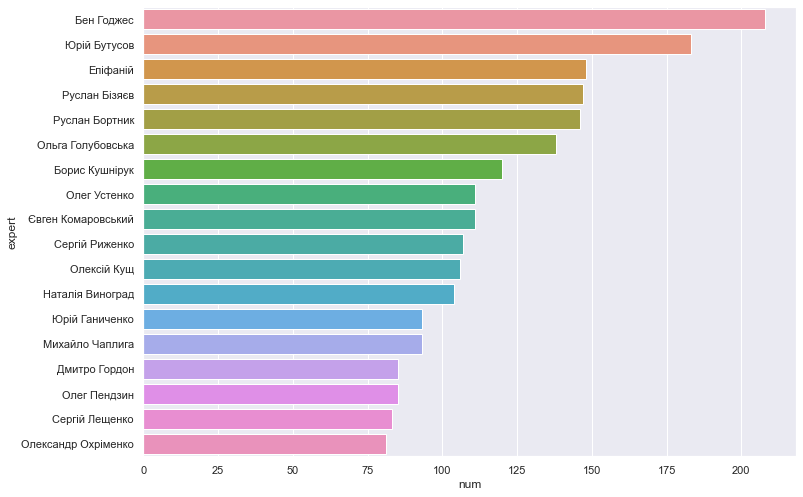

In [350]:
top_experts = all_ments_df[(~all_ments_df.del_flag)].head(20)

sns.barplot(x=top_experts.num, y=top_experts.expert, ci="sd")

In [278]:
all_ments_df[all_ments_df.expert=='Вадим Карасьов'].category

,Інциденти,Інше,Війна/Донбас,Економіка,Життя/lifestyle,Закордонна політика,Карантин,Коронавірус,Погода,Політика,Світ,Спорт,Суспільство,Технології,Шоу-бізнес
Вад Карас,0,0,2,4,0,13,0,0,0,37,1,1,0,0,0


In [279]:
prev_df[prev_df.expert=='Вадим Карасьов'].category

,Інциденти,Інше,Війна/Донбас,Економіка,Життя/lifestyle,Карантин,Коронавірус,Міжнародна політика,Погода,Політика,Світ,Спорт,Суспільство,Технології,Шоу-бізнес
Вад Карас,1,1,2,18,0,1,1,3,0,37,0,0,1,0,0


In [364]:
names_dict[names_dict.index.str.contains('Най')]

,num,stem_name,all_vars_str,id
name,,,,
Мас Най,153.0,Мас Най,Ма Най,391.0
Мустаф Най,74.0,Мустаф Най,NaN,852.0
Мас Найєм,26.0,Мас Найєм,Мас Найем,2302.0
Андр Найд,22.0,Андр Найд,Андре Найд,2672.0
Стівен Найт,14.0,Стівен Найт,NaN,4028.0
...,...,...,...,...
Васил Найден,1.0,Васил Найден,NaN,119037.0
Найджел Фарадж,1.0,Найджел Фарадж,NaN,119287.0
Дэвид Найв,1.0,Дэвид Найв,NaN,119642.0


In [363]:
all_ments_df[all_ments_df.index.str.contains('Най')]

domain                                                \
                    112.ua 24 канал Gazeta.ua LB.ua LIGA.net Obozrevatel   
Ерік Найман              0        0         0     0        0           8   
Мас Най                  0        2         2     1        2           1   
Мустаф Най               1        2         1     1        4           1   
Мустаф Найєм             0        0         0     0        0           0   
Євген Найштетік          0        0         0     0        0           0   
Найєм                    1        0         0     0        0           1   
Мустаф Найем             0        0         0     0        0           0   
Мас Найєм                0        0         0     0        0           0   
Найджел Гулд             0        0         0     0        0           0   
Найджел Хаддлестон       0        0         0     0        0           0   
Ігор Найд                0        0         0     0        0           0   
Марк Най                 0        0         0     0        0           0   
Адвокат Мас Най          0        0         0     0        0           0   
Іванн Найд               0        0         0     0        0           0   
Екснардеп Най            0        1         0     0        0           0   
Найджел Голденфельд      0        0         0     0        0           0   
Васил Найден             0        0         0     0        0           0   
Найджел Кроуфорд         0        0         0     0        0           0   
Найджел Хьюз             0        0         0     0        0           0   
Найем                    0        0         0     0        0           0   
Найджел Фарадж           0        0         0     0        0           0   
Дэвид Найв               0        0         0     0        0           0   
Владимир Найден          0        0         0     0        0           0   

                                                  ... category        \
                    Politeka ZIK ZN.UA Zaxid.net  ...     Світ Спорт   
Ерік Найман                8   0     0         0  ...        0     0   
Мас Най                    0   0     1         1  ...        0     0   
Мустаф Най                 0   0     0         0  ...        0     0   
Мустаф Найєм               0   0     0         1  ...        0     0   
Євген Найштетік            3   0     0         0  ...        0     0   
Найєм                      0   0     0         0  ...        0     0   
Мустаф Найем               0   0     0         0  ...        0     0   
Мас Найєм                  0   0     0         0  ...        0     0   
Найджел Гулд               0   0     2         0  ...        0     0   
Найджел Хаддлестон         0   0     0         0  ...        2     0   
Ігор Найд                  0   0     0         0  ...        0     0   
Марк Най                   0   0     0         0  ...        0     1   
Адвокат Мас Най            0   0     0         0  ...        0     0   
Іванн Найд                 0   0     0         0  ...        0     0   
Екснардеп Най              0   0     0         0  ...        0     0   
Найджел Голденфельд        0   0     0         0  ...        0     0   
Васил Найден               0   0     0         0  ...        0     0   
Найджел Кроуфорд           0   0     0         0  ...        0     0   
Найджел Хьюз               0   0     0         0  ...        0     0   
Найем                      0   0     0         0  ...        0     0   
Найджел Фарадж             0   0     0         0  ...        0     0   
Дэвид Найв                 0   0     0         0  ...        0     0   
Владимир Найден            0   0     0         0  ...        0     0   

                                                      num del_flag  \
                    Суспільство Технології Шоу-бізнес                
Ерік Найман                   0          0          0  45    False   
Мас Най                       0          0          0  43    False   
Мустаф Най                    0       

In [270]:
check_news_by_mention('Олег Ляшк', 'found_names_str', 12)

Вина за мільярдні збитки державних енергетичних компаній лежить на чиновниках НКРЕКП, які за півтора роки фактично зруйнували енергетичний сектор України
Про це заявив лідер Радикальної партії Олег Ляшко.
«Вся відповідальність за збитковість енергетичних компаній лежить на регуляторі. Дорегулювалися до того, що вся українська енергетика на кладовищі, на кладовищі в прямому смислі, вже не в реанімації», - заявив політик в ефірі телеканалу «Україна24».
Він заявив, що НКРЕКП регулятор проводить корупційну політику в інтересах певних людей, через що державні підприємства змушені нести збитки.
«Сотні тисяч людей без роботи, зарплати не платять, імпорт купуємо, грошей не вистачає, взаємні мільярдні борги, відсутність можливості розплачуватися по цих боргах. І фактично зупинення програми розвитку зеленої енергетики», - додав Ляшко.
Він заявив, що з огляду на катастрофічну ситуацію на енергоринку, президент Володимир Зеленський мусить невідкладно звільнити діючий склад НКРЕКП.
«Президент Зелен

### Find top-expert for every media

In [315]:
all_ments_df[~all_ments_df.del_flag]['Суспільне'].sort_values(ascending=False).head(18)

Володимир Панич            77
Андр Хайл                  26
Владисл Атрошенк           22
Володимир Кузьменк         22
Серг Кондрачук             22
Юл Лебедюк                 21
Валентин Лазарев           21
коронавірус Галин Слічн    20
Серг Ткачук                20
Ольг Хом                   20
Олен Лебединськ            20
Світлан Добровольськ       19
Юл Ткаченк                 19
Жанн Петрович              19
Ірин Мартинюк              18
Алл Кохан                  18
Михайл Смушак              18
Захарєв                    18
Name: Суспільне, dtype: int64

In [33]:
for i,r in all_ments_df[(~all_ments_df.del_flag)][[('domain', 'Гордон'), ('expert' ,'')]].sort_values(by=('domain', 'Гордон'), ascending=False).head(5).iterrows():
    print(r[('domain', 'Гордон')])
    print(r[('expert' ,'')])


KeyError: "None of [Index([('domain', 'Гордон'), ('expert', '')], dtype='object')] are in the [columns]"

In [34]:
df = pd.DataFrame(columns=['domain', 'id', 'expert', 'num'])
t = []
for d in news.domain_alias.unique():
    ments = all_ments_df[(~all_ments_df.del_flag)][[d, 'expert']].sort_values(by=d, ascending=False).head(5)
    for i, r in ments.iterrows():
        if r[d]>=20:
            a_series = pd.Series([ d, i, r.expert, r[d] ], index = df.columns)
            df = df.append(a_series, ignore_index=True)
#     print(d,m)

In [35]:
df.to_csv('top_experts_by_media.csv')

In [27]:
df['expert_count'] = None

In [55]:
top_exp_ments = df.groupby('domain').num.sum()
top_exp_ments_part = round((top_exp_ments/news.domain_alias.value_counts()[top_exp_ments.index])*100,2).sort_values()


In [56]:
top_exp_ments_part.index

Index(['Апостроф', 'Інтерфакс-Україна', 'LB.ua', 'ТСН', 'РБК-Україна',
       '112.ua', 'Gazeta.ua', 'Бабель', 'Радіо Свобода', 'УНІАН', 'НВ',
       'Еспресо ТВ', 'УНН', '24 канал', 'Українські новини', 'Фокус',
       'Цензор.НЕТ', 'Главком', 'Сьогодні', 'Телеграф', 'Факти',
       'КП в Украине', 'ZN.UA', 'LIGA.net', 'ZIK', 'Politeka', 'Znaj.ua',
       'Obozrevatel', 'Вести', 'Страна.ua', 'Гордон', 'ГолосUA'],
      dtype='object', name='domain')

In [26]:
for d in df.domain.unique():
    p = df[df.domain==d]
    n = len(df[(df.domain!=d)&(df.expert.isin(p.expert.values))].domain.unique())
    df.loc[df.domain==d, 'expert_count'] = n

In [27]:
domains_by_count = df.sort_values(by='expert_count', ascending=False).domain.unique()

In [28]:
domain = df.groupby('domain').expert_count.sum().sort_values(ascending=False).index
unique_names_counts = df.groupby('domain').expert_count.sum().sort_values(ascending=False)

In [29]:
len(df.domain.unique())

33

In [30]:
domains_by_count

array(['Главком', 'Факти', 'НВ', 'Gazeta.ua', 'Цензор.НЕТ', 'Гордон',
       'ZN.UA', 'Znaj.ua', 'Еспресо ТВ', 'LB.ua', 'LIGA.net', 'УНІАН',
       'Фокус', '24 канал', 'Бабель', 'КП в Украине', 'Вести',
       'Obozrevatel', 'Сьогодні', 'РБК-Україна', 'Страна.ua', 'Politeka',
       'Телеграф', 'УНН', 'ГолосUA', 'Українські новини', '112.ua',
       'Радіо Свобода', 'ZIK', 'Апостроф', 'Суспільне', 'ТСН',
       'Інтерфакс-Україна'], dtype=object)

In [61]:
data = []
k = 0
for d in top_exp_ments_part.index:
    p = df[df.domain==d]
    names = list(zip(list(p.expert.values), list(p.num.values)))
    name = '<br>'.join([' - '.join([n[0], str(n[1])+' зг.']) for n in names])
    data.append({
        'name': name,
        'data': [[k, top_exp_ments_part[d]]]
    })
    k+=1

In [34]:
data = []
for i in range(len(domains_by_count)):
    p = df[df.domain==domains_by_count[i]]
    names = list(zip(list(p.expert.values), list(p.num.values)))
    name = '<br>'.join([' - '.join([n[0], str(n[1])+' зг.']) for n in names])
    data.append({
        'name': name,
        'data': [[i, p.expert_count.iloc[0]]]
    })
    print(domains_by_count[i], '\t', int(p.expert_count.iloc[0]))

Главком 	 22
Факти 	 20
НВ 	 17
Gazeta.ua 	 17
Цензор.НЕТ 	 13
Гордон 	 13
ZN.UA 	 12
Znaj.ua 	 12
Еспресо ТВ 	 12
LB.ua 	 12
LIGA.net 	 12
УНІАН 	 12
Фокус 	 12
24 канал 	 12
Бабель 	 12
КП в Украине 	 11
Вести 	 11
Obozrevatel 	 11
Сьогодні 	 11
РБК-Україна 	 10
Страна.ua 	 9
Politeka 	 6
Телеграф 	 6
УНН 	 6
ГолосUA 	 5
Українські новини 	 5
112.ua 	 1
Радіо Свобода 	 1
ZIK 	 1
Апостроф 	 0
Суспільне 	 0
ТСН 	 0
Інтерфакс-Україна 	 0


In [72]:
data = []
for i in range(len(unique_names_counts)):
    p = df[df.domain==domain[i]]
    names = list(zip(list(p.expert.values), list(p.num.values)))
    name = '<br>'.join([' - '.join([n[0], str(n[1])+' зг.']) for n in names])
    data.append({
        'name': name,
        'data': [[i, unique_names_counts[i]]]
    })

In [26]:
experts_counts = df.expert.value_counts()

Юрій Бутусов            13
Євген Комаровський       7
Ольга Голубовська        7
Борис Кушнірук           6
Сергій Лещенко           6
Андрій Шевчишин          4
Арсеній Яценюк           3
Вадим Іосуб              3
Олег Пендзин             3
Олексій Якубін           3
Андрій Портнов           3
Віталій Шабунін          3
Руслан Бортник           3
Сергій Комісаренко       2
Сергій Томіленко         2
Артем Марчевський        2
Олексій Кущ              2
Андрій Гойлов            2
Катерина Котенкова       2
Євген Істребін           2
Віктор Бобиренко         1
Олександр Каленков       1
Микола Томенко           1
Володимир Паничев        1
Андрій Хайлов            1
Віталій Журавський       1
Володимир Кацман         1
Ігор Петренко            1
Епіфаній                 1
Михайло Фаворов          1
Всеволод Степанюк        1
Володимир Гройсман       1
Віктор Скаршевський      1
Василь Невмержицький     1
Володимир Широбоков      1
Віталій Портников        1
Борис Давиденко          1
Д

In [376]:
# domains = list(df.domain.unique())
domains = list(df.groupby('domain').num.sum().sort_values(ascending=False).index)
data = []
for e in df.expert.unique():
    exp_data = {}
    counts = []
    for d in domains:
        try:
            counts.append(df[(df.domain==d)&(df.expert==e)].num.iloc[0])
        except:
            counts.append(0)
    exp_data['name'] = e
    exp_data['data'] = counts
    data.append(exp_data)

In [21]:
check_news_by_mention('Русла Бортник', 'found_names_str', 72)

Сполученим Штатам не вдасться взяти під контроль увесь світ. Так заявив політолог і політик Вадим Карасьов у програмі «Що далі?» на каналі «Знай24».
На думку експерта, сьогодні світ повинен інвентаризувати геополітичну спадщину своєї колишньої епохи. Він також додає, що ніхто не може взяти під контроль увесь світ і керувати ним. «Навіть якби американці захотіли сьогодні залишатися таким глобальним поліцейським, гегемоном, лідером... Не вистачить сил», - міркує Карасьов.
Принагідно він коментує зміну влади в самих Сполучених Штатах. Так ось політика Байдена, як зазначає політолог, подібна на політику Трампа, хай між ними й була боротьба протягом президентських кампаній.
Карасьов відзначає певну здачу позицій США: вони забирають своїх військових з гарячої точки в Афганістані, не контролюють Близький Схід і його конфлікти, там з'явився Ізраїль. «Вони вже не можуть бути і на пострадянському просторі ключовою країною», - додає експерт.
Отже, він робить висновок, що Сполучені Штати також пот

### Check percentage of news with experts who had more than 50 mentions

In [88]:
more_than_50 = all_ments_df[(~all_ments_df.del_flag)&(all_ments_df.num>50)]
top_names = '|'.join(more_than_50.index.values)

In [90]:
top_names

'Юр Бутус|Ольг Голубовськ|Євген Комаровськ|Серг Лещенк|Борис Кушнірук|Олег Пендзин|Русла Бортник|Серг Комісаренк|Вітал Шабунін|Русла Бизя|Тимоф Милован|Арсен Яценюк|Андр Шевчишин|Епіфан|Олекс Кущ|Олександр Охріменк|Олег Устенк|Володимир Фесенк|Олександр Каленк|Вад Іосуб|Алекс Якубин|Серг Томіленк|Володимир Гройсман|Дмитр Гордон|Андр Портн|Христ Грозєв|Михайл Чаплиг|Андр Золотар|Володимир Омелян|Катерин Котенк|Павл Клімкін|Улян Супрун|Серг Риженк|Федір Лап|Серг Фурс|Ростисла Кравец|Серг Доротич|Віктор Петр|Натал Виноград|Серг Кравченк|Олег Ляшк|Руслан Рябошапк|Михайл Бродськ|Кирил Сазон|Тарас Загородн|Рікард Йозвяк|Андр Новак|Мас Най|Ігор Голован|Ігор Мосійчук|Тарас Жиравецьк|Вад Карас|Юр Луценк|Олег Сенц|Олександр Ярославськ|Андр Гойл|Алл Мироненк|Олекс Кошел|Олег Попенк|Святосл Вакарчук|Ігор Добруцьк|Павл Ковтонюк|Макс Тімченк|Арт Марчевськ|Кост Бондаренк|Ольг Айвазовськ|Дмитр Марунич|Євген Істребін|Дмитр Снєгир|Всеволод Степанюк|Серг Куюн|Ігор Мойсеєнк|Олег Самчук|Серг Філімон|Юр Кор

In [91]:
news['top_experts_ments'] = news.found_names_str.str.contains(top_names, na=False)

In [92]:
more_than_50[['expert', 'num']].to_csv('test.csv', index=False)

In [93]:
news.top_experts_ments.sum()

19859

In [94]:
d = sorted(news.domain_alias.unique())

In [95]:
news.domain_alias.value_counts()[d]

112.ua               12137
24 канал             38669
Gazeta.ua            20025
LB.ua                 8785
LIGA.net             11195
Obozrevatel          23394
Politeka             19836
ZIK                   9570
ZN.UA                12281
Zaxid.net             4590
Znaj.ua              20728
Інтерфакс-Україна    10723
Апостроф             13204
Бабель                6197
Букви                 6995
Вголос                9794
Вести                14482
Главком              23416
ГолосUA              21538
Гордон               12807
Громадське            4546
Економічна правда     2721
Еспресо ТВ           11990
КП в Украине          9689
Корреспондент.net    17275
НВ                   21063
РБК-Україна          15583
Радіо Свобода         5895
Страна.ua            15219
Суспільне            31530
Сьогодні             21171
ТСН                  14503
Телеграф             11301
УНІАН                19408
УНН                  17407
Українська правда     7435
Українські новини    11649
У

In [97]:
round((news.groupby('domain_alias').top_experts_ments.sum()/news.domain_alias.value_counts()[d]*100).sort_values(ascending=False),2)


domain_alias
Гордон               8.01
ГолосUA              6.86
Obozrevatel          6.28
Politeka             5.35
Znaj.ua              5.21
ZIK                  4.72
КП в Украине         4.58
Вести                4.51
Телеграф             4.39
Главком              4.10
Страна.ua            3.76
Апостроф             3.75
Українські новини    3.74
Фокус                3.48
Цензор.НЕТ           3.46
Сьогодні             3.33
ZN.UA                3.20
Gazeta.ua            2.96
Радіо Свобода        2.95
Факти                2.93
Еспресо ТВ           2.73
24 канал             2.61
УНІАН                2.61
Громадське           2.60
РБК-Україна          2.55
Факти ICTV           2.53
НВ                   2.53
УНН                  2.46
112.ua               2.36
Zaxid.net            2.24
Бабель               2.24
LIGA.net             2.14
LB.ua                2.06
Букви                1.89
Інтерфакс-Україна    1.79
Вголос               1.68
ТСН                  1.56
Корреспондент.net    1.26

In [68]:
top_experts[['expert', 'num']]

,expert,num
,,
Юр Бутус,Юрій Бутусов,777
Ольг Голубовськ,Ольга Голубовська,644
Євген Комаровськ,Євген Комаровський,430
Борис Кушнірук,Борис Кушнірук,426
Серг Лещенк,Сергій Лещенко,425
Олег Пендзин,Олег Пендзин,380
Вітал Шабунін,Віталій Шабунін,348
Серг Комісаренк,Сергій Комісаренко,344
Русла Бортник,Руслан Бортник,343


In [237]:
all_ments_df[~all_ments_df.del_flag&(all_ments_df.num>50)].shape

(133, 64)

### Find media that mention each of top-expert most often

In [99]:
cols = list(all_ments_df.columns)[:-5]

In [106]:
all_ments_df[(~all_ments_df.del_flag)&(all_ments_df.num>100)].sort_values(by='num', ascending=False)['domain']

domain                                                \
                 112.ua 24 канал Gazeta.ua LB.ua LIGA.net Obozrevatel   
Юр Бутус              4       76        34    20       50          38   
Ольг Голубовськ       8        5        27     4        0         143   
Євген Комаровськ      1        0        12     0        0           5   
Серг Лещенк           1       70         5     3        3          19   
Борис Кушнірук        0        5         7     0        0          72   
...                 ...      ...       ...   ...      ...         ...   
Ігор Мойсеєнк         3        0         4     1        4           4   
Олег Самчук           3        4         3     4        4           2   
Серг Філімон          0        1         0     5        0           5   
Юр Корольчук          0        5         4     0        0           2   
Борис Бабін           1        7        10     0        1          22   

                                               ...   category    month  \
                 Politeka ZIK ZN.UA Zaxid.net  ... Шоу-бізнес December   
Юр Бутус               10   4    40         8  ...          3      372   
Ольг Голубовськ        18  14     7         0  ...          0      158   
Євген Комаровськ       13  12     0         0  ...          5      164   
Серг Лещенк             3   1    22         5  ...          3       81   
Борис Кушнірук         72   0     1         0  ...          0      100   
...                   ...  ..   ...       ...  ...        ...      ...   
Ігор Мойсеєнк           4   3     1         0  ...          0        8   
Олег Самчук             1   1     1        15  ...          0       42   
Серг Філімон            0   0     1         1  ...          0        0   
Юр Корольчук            1   1     0         0  ...          0       23   
Борис Бабін             0   1     0         0  ...          1       35   

                                         num del_flag              expert  \
                 January February March                                     
Юр Бутус             147      134   197  850    False        Юрій Бутусов   
Ольг Голубовськ      230       93   173  654    False   Ольга Голубовська   
Євген Комаровськ     114      110   156  544    False  Євген Комаровський   
Серг Лещенк           63      173   136  453    False      Сергій Лещенко   
Борис Кушнірук        82      148    97  427    False      Борис Кушнірук   
...                  ...      ...   ...  ...      ...                 ...   
Ігор Мойсеєнк         11        7    78  104    False      Ігор Мойсеєнко   
Олег Самчук            4       19    39  104    False         Олег Самчук   
Серг Філімон           0        0   102  102    False    Сергій Філімонов   
Юр Корольчук          32       24    23  102    False      Юрій Корольчук   
Борис Бабін           24       19    23  101    False         Борис Бабін   

                 expert_id     image_name  
                                           
Юр Бутус              43.0      y_butusov  
Ольг Голубовськ       67.0   o_holubovska  
Євген Комаровськ      75.0  y_komarovskyi  
Серг Лещенк           94.0   s_leshchenko  
Борис Кушнірук       124.0    b_kushniruk  
...                    ...            ...  
Ігор Мойсеєнк        588.0   i_moiseienko  
Олег Самчук          562.0      o_samchuk  
Серг Філімон         587.0    s_filimonov  
Юр Корольчук         576.0    y_korolchuk  
Борис Бабін          584.0        b_babin  

[76 rows x 66 columns]

In [107]:
experts_by_domains = all_ments_df[(~all_ments_df.del_flag)&(all_ments_df.num>100)].sort_values(by='num', ascending=False)['domain'].T.copy()
for col in experts_by_domains.columns:
    experts_by_domains[col] = round(experts_by_domains[col]/experts_by_domains[col].sum()*100, 2)

In [111]:
experts_by_domains['Михайл Бродськ']

112.ua                0.00
24 канал              7.46
Gazeta.ua             1.49
LB.ua                 0.75
LIGA.net              0.00
Obozrevatel          54.48
Politeka              0.00
ZIK                   0.00
ZN.UA                 6.72
Zaxid.net             0.00
Znaj.ua               0.00
Інтерфакс-Україна     0.75
Апостроф              1.49
Бабель                1.49
Букви                 0.00
Вголос                0.00
Вести                 0.00
Главком               1.49
ГолосUA               0.00
Гордон                7.46
Громадське            1.49
Економічна правда     0.00
Еспресо ТВ            1.49
КП в Украине          0.00
Корреспондент.net     2.24
НВ                    0.00
РБК-Україна           0.00
Радіо Свобода         2.24
Страна.ua             0.00
Суспільне             0.00
Сьогодні              2.24
ТСН                   0.75
Телеграф              0.00
УНІАН                 0.00
УНН                   0.00
Українська правда     0.75
Українські новини     0.00
У

In [90]:
experts_by_domains.iloc[:, :30]

,Юр Бутус,Ольг Голубовськ,Євген Комаровськ,Серг Лещенк,Борис Кушнірук,Олег Пендзин,Русла Бортник,Серг Комісаренк,Вітал Шабунін,Русла Бизя,...,Алекс Якубин,Серг Томіленк,Володимир Гройсман,Дмитр Гордон,Андр Портн,Христ Грозєв,Михайл Чаплиг,Андр Золотар,Володимир Омелян,Катерин Котенк
112.ua,0.47,1.22,0.18,0.22,0.00,0.26,1.57,1.11,0.57,0.00,...,0.93,2.86,1.01,0.51,3.61,0.00,3.11,1.04,0.00,0.60
24 канал,8.94,0.76,0.00,15.45,1.17,1.83,0.52,5.26,21.02,0.00,...,0.00,4.29,2.51,5.61,4.12,3.63,0.00,0.52,0.53,0.60
Gazeta.ua,4.00,4.13,2.21,1.10,1.64,0.79,0.00,2.77,6.25,0.35,...,0.00,0.48,0.00,0.00,1.03,1.55,1.04,1.56,0.53,0.60
LB.ua,2.35,0.61,0.00,0.66,0.00,0.00,0.00,0.00,1.14,0.00,...,0.00,0.48,1.51,0.51,0.52,0.52,0.00,0.00,0.00,0.00
LIGA.net,5.88,0.00,0.00,0.66,0.00,0.00,0.00,0.83,3.12,0.00,...,0.00,0.00,0.50,1.02,0.52,8.81,0.00,0.00,0.53,0.00
Obozrevatel,4.47,21.87,0.92,4.19,16.86,6.81,0.52,8.31,3.69,0.00,...,0.00,1.43,15.58,12.76,0.00,3.11,1.55,3.65,17.46,0.00
Politeka,1.18,2.75,2.39,0.66,16.86,5.50,11.81,1.66,0.00,14.53,...,1.85,0.00,6.03,2.04,0.00,0.52,24.35,4.17,17.46,45.78
ZIK,0.47,2.14,2.21,0.22,0.00,1.05,3.67,1.39,0.85,0.35,...,8.80,2.86,0.50,0.00,4.12,1.04,8.81,0.52,0.53,0.00
ZN.UA,4.71,1.07,0.00,4.86,0.23,0.26,0.00,4.99,5.68,0.00,...,0.00,0.95,1.51,0.51,1.03,2.07,0.00,0.52,0.53,0.00
Zaxid.net,0.94,0.00,0.00,1.10,0.00,0.00,0.00,0.00,0.85,0.00,...,0.00,0.48,0.00,0.00,1.55,0.52,0.00,0.00,0.00,0.00


[Text(0, 0, 'Юр Бутус'),
 Text(1, 0, 'Ольг Голубовськ'),
 Text(2, 0, 'Євген Комаровськ'),
 Text(3, 0, 'Серг Лещенк'),
 Text(4, 0, 'Борис Кушнірук'),
 Text(5, 0, 'Олег Пендзин'),
 Text(6, 0, 'Русла Бортник'),
 Text(7, 0, 'Серг Комісаренк'),
 Text(8, 0, 'Вітал Шабунін'),
 Text(9, 0, 'Тимоф Милован'),
 Text(10, 0, 'Русла Бизя'),
 Text(11, 0, 'Арсен Яценюк'),
 Text(12, 0, 'Андр Шевчишин'),
 Text(13, 0, 'Епіфан'),
 Text(14, 0, 'Олекс Кущ'),
 Text(15, 0, 'Олександр Охріменк'),
 Text(16, 0, 'Олег Устенк'),
 Text(17, 0, 'Володимир Фесенк'),
 Text(18, 0, 'Олександр Каленк'),
 Text(19, 0, 'Вад Іосуб')]

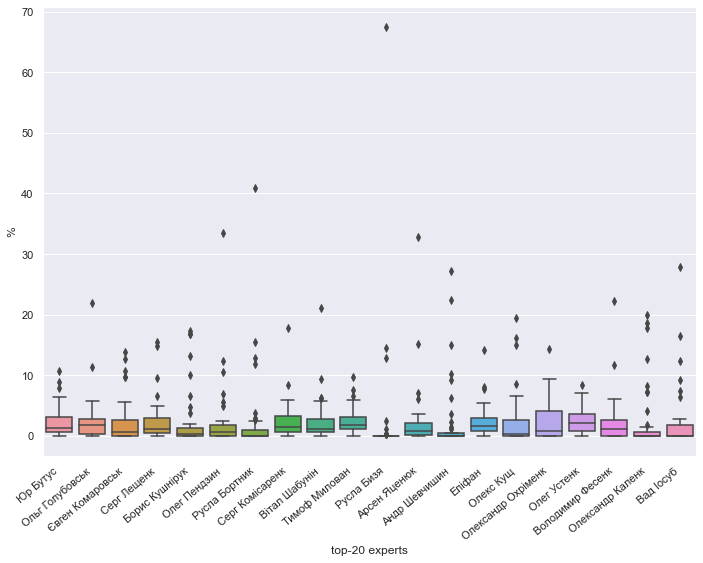

In [26]:
boxplot = sns.boxplot(data = experts_by_domains.iloc[:, :20])
boxplot.set(xlabel='top-20 experts', ylabel='%')
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=40, ha="right")

In [313]:
def find_outliers(df, col, a=1.5):
    qlow = df[col].quantile(0.25)
    qhigh = df[col].quantile(0.75)
    iqr = qhigh - qlow
    outliers = df[(df[col] > (qhigh+a*iqr))|(df[col] < (qlow-a*iqr))][col]
    return outliers

In [316]:
top_names = top_experts.index    

In [317]:
for n in top_names:
    q1 = round(experts_by_domains[n].quantile(0.25), 2)
    q3 = round(experts_by_domains[n].quantile(0.75), 2)
    iqr = q3 - q1
    
#     low = experts_by_domains[experts_by_domains[n]>=(q1-1.5*iqr)][n].min()
#     high = experts_by_domains[experts_by_domains[n]<=(q3+1.5*iqr)][n].max()
    low = experts_by_domains[stats.zscore(experts_by_domains[n])<=3][n].min()
    high = experts_by_domains[stats.zscore(experts_by_domains[n])<=3][n].max()
    median = round(experts_by_domains[n].median(), 2)
    p = [all_ments_df.loc[n].expert,
         low,
         q1,
         median,
         q3, 
         high]
    
#     d = {
#         'x':all_ments_df.loc[n].expert.iloc[0],
#         'low': low,
#         'q1': q1,
#         'median': median,
#         'q3': q3,
#         'high': high
#     }
    print(p, ',')

['Юрій Бутусов', 0.0, 0.53, 1.29, 3.06, 8.94] ,
['Ольга Голубовська', 0.0, 0.23, 1.84, 2.75, 11.31] ,
['Євген Комаровський', 0.0, 0.0, 0.64, 2.67, 12.68] ,
['Сергій Лещенко', 0.0, 0.5, 1.1, 2.87, 9.49] ,
['Борис Кушнірук', 0.0, 0.0, 0.23, 1.35, 16.86] ,
['Олег Пендзин', 0.0, 0.0, 0.66, 1.83, 12.3] ,
['Руслан Бортник', 0.0, 0.0, 0.0, 0.99, 15.49] ,
['Сергій Комісаренко', 0.0, 0.62, 1.39, 3.18, 8.31] ,
['Віталій Шабунін', 0.0, 0.57, 1.14, 2.77, 9.38] ,
['Тимофій Милованов', 0.0, 1.04, 1.73, 3.11, 7.61] ,
['Руслан Бізяєв', 0.0, 0.0, 0.0, 0.0, 14.53] ,
['Арсеній Яценюк', 0.0, 0.09, 0.71, 2.12, 15.19] ,
['Андрій Шевчишин', 0.0, 0.0, 0.0, 0.37, 15.02] ,
['Епіфаній', 0.0, 0.86, 1.53, 2.95, 8.02] ,
['Олексій Кущ', 0.0, 0.0, 0.2, 2.63, 14.98] ,
['Олександр Охріменко', 0.0, 0.0, 0.82, 4.0, 9.43] ,
['Олег Устенко', 0.0, 0.84, 2.09, 3.56, 7.11] ,
['Володимир Фесенко', 0.0, 0.0, 1.08, 2.58, 11.59] ,
['Олександр Каленков', 0.0, 0.0, 0.0, 0.68, 17.73] ,
['Вадим Іосуб', 0.0, 0.0, 0.0, 1.83, 16.44] ,


In [320]:
top_names

Index(['Юр Бутус', 'Ольг Голубовськ', 'Євген Комаровськ', 'Серг Лещенк',
       'Борис Кушнірук', 'Олег Пендзин', 'Русла Бортник', 'Серг Комісаренк',
       'Вітал Шабунін', 'Тимоф Милован', 'Русла Бизя', 'Арсен Яценюк',
       'Андр Шевчишин', 'Епіфан', 'Олекс Кущ', 'Олександр Охріменк',
       'Олег Устенк', 'Володимир Фесенк', 'Олександр Каленк', 'Вад Іосуб'],
      dtype='object')

In [318]:
media_df = pd.DataFrame(columns=['expert','domain', 'part'])
for n in top_names:
    out = experts_by_domains[stats.zscore(experts_by_domains[n])>3][n].to_frame(name='part')
#     out = find_outliers(experts_by_domains, n).to_frame(name='part')
    out['domain'] = out.index
    out['expert'] = all_ments_df.loc[n].expert
    media_df.append(out[['expert','domain', 'part']], ignore_index=True)
    media_df = pd.concat([media_df, out[['expert','domain', 'part']].reset_index(drop=True)])

In [319]:
media_df

,expert,domain,part
0,Юрій Бутусов,Цензор.НЕТ,10.71
0,Ольга Голубовська,Obozrevatel,21.87
0,Євген Комаровський,Телеграф,13.79
0,Сергій Лещенко,24 канал,15.45
1,Сергій Лещенко,Главком,14.79
0,Борис Кушнірук,Znaj.ua,17.33
0,Олег Пендзин,ГолосUA,33.51
0,Руслан Бортник,ГолосUA,40.94
0,Сергій Комісаренко,УНІАН,17.73
0,Віталій Шабунін,24 канал,21.02


In [44]:
for i,r in media_df.iterrows():
    d = {'x': list(top_experts.expert.values).index(r.expert),
        'y': r.part,
        'name': r.domain}
    print(d, ',')

{'x': 0, 'y': 10.71, 'name': 'Цензор.НЕТ'} ,
{'x': 1, 'y': 21.87, 'name': 'Obozrevatel'} ,
{'x': 2, 'y': 13.79, 'name': 'Телеграф'} ,
{'x': 3, 'y': 15.45, 'name': '24 канал'} ,
{'x': 3, 'y': 14.79, 'name': 'Главком'} ,
{'x': 4, 'y': 17.33, 'name': 'Znaj.ua'} ,
{'x': 5, 'y': 33.51, 'name': 'ГолосUA'} ,
{'x': 6, 'y': 40.94, 'name': 'ГолосUA'} ,
{'x': 7, 'y': 17.73, 'name': 'УНІАН'} ,
{'x': 8, 'y': 21.02, 'name': '24 канал'} ,
{'x': 9, 'y': 67.47, 'name': 'ГолосUA'} ,
{'x': 10, 'y': 9.69, 'name': 'Главком'} ,
{'x': 11, 'y': 32.86, 'name': 'Сьогодні'} ,
{'x': 12, 'y': 27.11, 'name': 'Страна.ua'} ,
{'x': 12, 'y': 22.34, 'name': 'Сьогодні'} ,
{'x': 13, 'y': 14.12, 'name': 'Главком'} ,
{'x': 14, 'y': 19.43, 'name': 'Politeka'} ,
{'x': 14, 'y': 16.19, 'name': 'Znaj.ua'} ,
{'x': 15, 'y': 14.34, 'name': 'Сьогодні'} ,
{'x': 16, 'y': 8.37, 'name': 'Гордон'} ,
{'x': 17, 'y': 22.32, 'name': '24 канал'} ,
{'x': 18, 'y': 20.0, 'name': 'Obozrevatel'} ,
{'x': 18, 'y': 18.64, 'name': 'Politeka'} ,
{'x': 

In [52]:
l = []
for m in media_df.domain.unique():
    print(m)
    part = media_df[media_df.domain==m]
#     d = []
    for i,r in part.iterrows():
        l.append([list(top_experts.expert.values).index(r.expert), r.part])
#     print(d)
print(l)

Цензор.НЕТ
Обозреватель
Znaj.ua
Politeka
Главком
24 канал
ГолосUA
УНІАН
Апостроф
Страна.ua
Сьогодні
Українські новини
Радіо Свобода
[[1, 11.64], [2, 20.17], [4, 17.27], [3, 14.69], [4, 17.27], [4, 17.27], [5, 16.72], [10, 12.4], [12, 10.53], [6, 20.86], [19, 22.22], [7, 31.02], [9, 41.56], [17, 78.95], [8, 22.57], [11, 20.52], [13, 26.48], [14, 31.13], [16, 13.54], [15, 70.5], [18, 16.67]]


### Check mentions changing during 4 month

In [230]:
all_ments_df[~all_ments_df.del_flag].iloc[:30].month

,December,January,February,March
Юр Бутус,372,147,134,194
Ольг Голубовськ,158,230,93,173
Євген Комаровськ,164,114,110,131
Серг Лещенк,81,63,173,136
Борис Кушнірук,100,82,148,97
Русла Бортник,77,47,119,138
Олег Пендзин,108,63,103,107
Серг Комісаренк,210,27,20,104
Вітал Шабунін,119,52,107,74
Тимоф Милован,94,36,98,61


In [228]:
top_experts.month['March'].values
# .to_csv('test1.csv')

array([194, 173, 131, 136,  97, 138, 107, 104,  74,  61,  99,  71,  54,
        20,  71,  52,  61,  53,  60,  96])

In [229]:
for i,r in top_experts.iterrows():
    print(top_experts.month)

                    December  January  February  March
Юр Бутус                 372      147       134    194
Ольг Голубовськ          158      230        93    173
Євген Комаровськ         164      114       110    131
Серг Лещенк               81       63       173    136
Борис Кушнірук           100       82       148     97
Русла Бортник             77       47       119    138
Олег Пендзин             108       63       103    107
Серг Комісаренк          210       27        20    104
Вітал Шабунін            119       52       107     74
Тимоф Милован             94       36        98     61
Русла Бизя                45       66        79     99
Арсен Яценюк              25       71       116     71
Андр Шевчишин             71       73        75     54
Епіфан                   194       37        11     20
Олекс Кущ                 50       42        84     71
Олександр Охріменк        50       72        70     52
Олег Устенк               41       87        50     61
Володимир 

In [57]:
cols = list(all_ments_df.columns[:-22])+list(all_ments_df.columns[-4:])
(all_ments_df[~all_ments_df.del_flag].head(50)[cols]).to_csv('experts_top_datasets/all_mentions.csv')

### Check experts by categories

In [116]:
df1 = by_cat_df['Суспільство']
df1[(df1.num>30)&(~df1.del_flag)&(df1.expert.notna())][['expert', 'num']]

,expert,num
Епіфан,Епіфаній,144
Ігор Мойсеєнк,Ігор Мойсеєнко,55
Олег Самчук,Олег Самчук,53
Серг Доротич,Сергій Доротич,45
Олег Сенц,Олег Сенцов,41
Ігор Добруцьк,Ігор Добруцький,38
Андр Портн,Андрій Портнов,35


In [67]:
df = by_cat_df['Економіка']
df[(df.num>50)&(~df.del_flag)&(df.expert.notna())][['expert', 'num']]

,expert,num
Борис Кушнірук,Борис Кушнірук,372
Олег Пендзин,Олег Пендзин,363
Андр Шевчишин,Андрій Шевчишин,273
Олекс Кущ,Олексій Кущ,221
Вад Іосуб,Вадим Іосуб,217
Олег Устенк,Олег Устенко,214
Олександр Каленк,Олександр Каленков,203
Олександр Охріменк,Олександр Охріменко,191
Тимоф Милован,Тимофій Милованов,179
Катерин Котенк,Катерина Котенкова,123


In [81]:
all_ments_df.loc['Юр Романенк']

112.ua                            0
24 канал                          1
Gazeta.ua                         0
LB.ua                             1
LIGA.net                          0
Obozrevatel                       3
Politeka                         28
ZIK                               0
ZN.UA                             1
Zaxid.net                         0
Znaj.ua                          31
Інтерфакс-Україна                 0
Апостроф                          3
Бабель                            0
Букви                             0
Вголос                            0
Вести                             1
Главком                           0
ГолосUA                           1
Гордон                            2
Громадське                        0
Економічна правда                 0
Еспресо ТВ                        0
КП в Украине                      1
Корреспондент.net                 0
НВ                                1
РБК-Україна                       0
Радіо Свобода               

In [27]:
for k in by_cat_df.keys():
    df = by_cat_df[k]
    print(k)
    print(df[~df.del_flag].head(30)[['num', 'expert']], '\n')
#     .to_csv('experts_top_datasets/'+k+'.csv')

Економіка
                    num                expert
Борис Кушнірук      372        Борис Кушнірук
Олег Пендзин        363          Олег Пендзин
Андр Шевчишин       273       Андрій Шевчишин
Олекс Кущ           221           Олексій Кущ
Вад Іосуб           217           Вадим Іосуб
Олег Устенк         214          Олег Устенко
Олександр Каленк    203    Олександр Каленков
Олександр Охріменк  191   Олександр Охріменко
Тимоф Милован       179     Тимофій Милованов
Катерин Котенк      123    Катерина Котенкова
Андр Гойл           121         Андрій Гойлов
Андр Новак          118          Андрій Новак
Серг Куюн           103           Сергій Куюн
Серг Фурс           100          Сергій Фурса
Юр Корольчук         94        Юрій Корольчук
Володимир Гройсман   93    Володимир Гройсман
Олег Попенк          93          Олег Попенко
Васил Невмержицьк    92  Василь Невмержицький
Макс Тімченк         90       Максим Тімченко
Володимир Омелян     88      Володимир Омелян
Олекс Дорошенк       84 

In [90]:
df = cats_and_month_dfs['economics_feb_2021']
df[~df.del_flag].head(30)

domain                                                      \
                   112.ua 24tv.ua apostrophe.ua babel.ua bykvu.com espreso.tv   
Борис Кушнірук          0       3             0        0         0          2   
Олег Пендзин            1       3             2        0         0          3   
Олекс Кущ               1       1             1        0         0          0   
Андр Шевчишин           0       0             1        0         0          0   
Олександр Каленк        0       0             0        0         0          0   
Тимоф Милован           0       3             2        0         1          2   
Олександр Охріменк      0       0             1        0         0          0   
Вад Іосуб               0       0             3        0         0          0   
Андр Новак              0       0             1        0         0          0   
Олег Попенк             0       0             4        0         0          1   
Катерин Котенк          0       0             0        0         0          0   
Олег Устенк             1       3             0        0         0          1   
Макс Тімченк            0       1             0        0         1          1   
Анатол Кін              0       0             0        0         0          0   
Анатол Старовойт        0       0             0        0         0          0   
Володимир Омелян        0       0             0        0         0          0   
Серг Фурс               0       6             2        0         0          1   
Володимир Гройсман      1       0             0        0         0          1   
Серг Куюн               0       0             2        0         0          0   
Олекс Дорошенк          1       0             0        0         0          0   
Юр Атаманюк             0       0             0        0         0          0   
Андр Гойл               0       0             0        0         0          0   
Юр Корольчук            0       0             0        0         0          0   
Станісл Зінченк         0       0             0        0         0          0   
Дмитр Олійник           0       0             0        0         0          0   
Васил Невмержицк        0       0             0        0         0          0   
Дмитр Марунич           0       1             0        0         0          0   
Геннад Рябц             0       0             0        0         0          0   
Світлан Литвин          0       4             0        0         0          0   
Віктор Скаршевськ       0       0             0        0         0          0   

                                                             ...           \
                   fakty.com.ua fakty.ua focus.ua gazeta.ua  ... vesti.ua   
Борис Кушнірук                0        0        0         2  ...        0   
Олег Пендзин                  1        0        1         1  ...        0   
Олекс Кущ                     1        0        0         7  ...        3   
Андр Шевчишин                 0        5        0         0  ...        0   
Олександр Каленк              0        0        0         0  ...        0   
Тимоф Милован                 2        0        0         2  ...        8   
Олександр Охріменк            0        1        1         3  ...        4   
Вад Іосуб                     1        4        0         2  ...        0   
Андр Новак                    0        0        0         1  ...        0   
Олег Попенк                   0        0        0         1  ...        7   
Катерин Котенк                0        0        0         0  ...        0   
Олег Устенк                   1        0        1         0  ...        4   
Макс Тімченк                  0        0        0         0  ...        0   
Анатол Кін                    0        0        0         0  ...        0   
Анатол Старовойт              0        0        0         0  ...        0   
Володимир Омелян              0        0        0         0  ...        0   
Серг Фурс                     0        1

In [83]:
# df = cats_and_month_dfs['inter_pol_jan_2021']
# df[~df.del_flag].head(30).index

In [409]:
for k, v in cats_and_month_dfs.items():
    v[v.del_flag==False].iloc[:20].to_csv('experts_datasets/experts_'+k+'.csv')

In [60]:
experts = all_ments_df[all_ments_df.expert.notna()][['expert_id', 'expert', 'num']].copy()

In [98]:
all_ments_df[~all_ments_df.del_flag].head(20)['category']

,Інциденти,Інше,Війна/Донбас,Економіка,Життя/lifestyle,Карантин,Коронавірус,Міжнародна політика,Погода,Політика,Світ,Спорт,Суспільство,Технології,Шоу-бізнес
Наталк Діденк,18,6,0,0,7,1,0,0,1069,1,4,0,7,0,2
Юр Бутус,181,0,47,6,0,0,1,14,0,396,2,0,5,0,1
Ольг Голубовськ,8,1,0,12,6,11,395,2,0,38,1,0,7,0,0
Євген Комаровськ,0,3,0,1,234,2,125,0,0,11,1,0,4,4,3
Борис Кушнірук,1,0,0,311,1,0,0,1,0,10,0,0,6,0,0
Серг Лещенк,48,1,1,20,0,0,0,8,0,229,0,0,8,0,2
Серг Гармаш,0,2,283,1,0,0,2,7,0,17,0,0,1,0,0
Вітал Шабунін,103,9,2,1,0,0,1,9,0,152,1,0,0,0,0
Олег Пендзин,0,0,0,258,2,0,0,4,0,5,1,0,2,1,1
Серг Комісаренк,1,3,0,4,1,0,222,1,0,7,1,1,12,4,0


In [300]:
experts['comment'] = None

In [301]:
for k, v in endings_dict.items():
    if len(v) > 1:
        experts.loc[k, 'comment'] = v[-1]

In [308]:
experts.to_csv('experts_profiles.csv', index=False)

In [307]:
# experts.columns = experts.columns.droplevel()
experts.columns = ['expert_id', 'expert', 'comment']
experts

,expert_id,expert,comment
Наталк Діденк,16,Наталка Діденко,синоптикиня
Юр Бутус,40,Юрій Бутусов,None
Ольг Голубовськ,53,Ольга Голубовська,провідний інфекціоніст МОЗ
Євген Комаровськ,71,Євген Комаровський,None
Борис Кушнірук,86,Борис Кушнірук,економіст
...,...,...,...
Діпт Гурдасан,2080,Діпті Гурдасані,епідеміолог з Лондонського університету короле...
Філ Дормітцер,2253,Філ Дормітцер,один из ведущих ученых Pfizer в области вирусн...
Серг Тит,3289,Сергій Титов,Заступник головного редактора російського інте...
Дмитр Марк,4029,Дмитро Марков,Російський фотограф


In [114]:
all_ments_df['id'] = range(len(all_ments_df))

In [117]:
all_ments_df[['num', 'del_flag', 'id', 'full_name']].to_csv('all_mentions_with_id.csv')

In [86]:
news.mycategory.value_counts().index

Index(['Інциденти', 'Політика', 'Коронавірус', 'Економіка', 'Світ',
       'Шоу-бізнес', 'Спорт', 'Суспільство', 'Міжнародна політика',
       'Життя/lifestyle', 'Технології', 'Війна/Донбас', 'Погода', 'Карантин',
       'Інше'],
      dtype='object')

In [62]:
names_counts_df[names_counts_df.index.str.contains('Троф')].num

Серг Трофім                9.0
Серг Троф                  6.0
Трофимчук                  4.0
Трофимов                   3.0
Серг Трофим                3.0
Серг Трофимов              3.0
Ольг Трофімцев             3.0
Ігор Трофімчук             2.0
Олен Трофимчук             2.0
Едуард Трофименк           2.0
Трофімов                   2.0
Ольг Трофимцев             1.0
Олен Трофименк             1.0
Трофанівк                  1.0
Сергі Трофімов Сергієнк    1.0
Троф                       1.0
Альон Трофимчук            1.0
Оп Трофимов                1.0
Юр Трофимович Тимошенк     1.0
Сергі Трофімов             1.0
Мирослав Трофимчук         1.0
Оп Трофім                  1.0
Олександр Трофимчук        1.0
Вікторі Трофименк          1.0
Кирил Трофімчук            1.0
Оп Троф                    1.0
Серг Трофанчук             1.0
Тетян Трофименк            1.0
Алекс Трофим               1.0
Олег Трофимюк              1.0
Трофим                     1.0
Ольг Трофименк             1.0
Віктор Т

In [78]:
all_ments_df.to_csv('experts_all.csv')

In [107]:
all_ments_df[all_ments_df.index.str.contains('Діденк')]

domain                                                 \
                 112.ua 24 канал Gazeta.ua LB.ua LIGA.net Politeka ZIK   
Наталк Діденк         1       71        71     1        4       40  19   
Олег Діденк           1        0         0     0        0        0   1   
Катерин Діденк        0        0         0     0        2        0   0   
Григор Діденк         0        0         0     0        0        0   0   
Віктор Діденк         0        0         0     0        0        0   0   
Юр Діденк             0        1         0     0        0        0   0   
Олекс Діденк          0        0         0     0        0        0   1   
Олександр Діденк      0        0         0     0        0        0   0   
Дмитр Діденк          0        0         0     0        0        0   0   
Ірин Діденк           0        0         0     0        0        0   0   
Марин Діденк          0        0         0     0        0        0   0   

                                                      ...   category  \
                 Zaxid.net Znaj.ua Інтерфакс-Україна  ... Технології   
Наталк Діденк            1      81                 0  ...          0   
Олег Діденк              0       0                 1  ...          0   
Катерин Діденк           0       0                 2  ...          0   
Григор Діденк            0       0                 0  ...          0   
Віктор Діденк            0       0                 0  ...          0   
Юр Діденк                0       0                 0  ...          0   
Олекс Діденк             0       0                 0  ...          0   
Олександр Діденк         0       0                 0  ...          0   
Дмитр Діденк             0       0                 0  ...          0   
Ірин Діденк              1       0                 0  ...          0   
Марин Діденк             0       0                 0  ...          0   

                               month                          num del_flag  \
                 Шоу-бізнес December January February March                  
Наталк Діденк             2      397     369      349     4  1119     True   
Олег Діденк               0        1       0        1    12    14    False   
Катерин Діденк            0        1       1        0     6     8    False   
Григор Діденк             0        4       0        0     1     5    False   
Віктор Діденк             0        0       0        0     4     4    False   
Юр Діденк                 0        1       0        1     1     3    False   
Олекс Діденк              0        2       0        0     0     2    False   
Олександр Діденк          0        0       0        0     1     1    False   
Дмитр Діденк              0        0       0        0     1     1    False   
Ірин Діденк               0        0       0        1     0     1    False   
Марин Діденк              0        1       0        0     0     1    False   

                           expert expert_id  
                                             
Наталк Діденк     Наталка Діденко      23.0  
Олег Діденк                  None    3699.0  
Катерин Діденк               None    6234.0  
Григор Діденк                None    5282.0  
Віктор Діденк                None    9693.0  
Юр Діденк                    None   15982.0  
Олекс Діденк                 None   22319.0  
Олександр Діденк             None   53566.0  
Дмитр Діденк                 None   58258.0  
Ірин Діденк                  None   70036.0  
Марин Діденк                 None   25929.0  

[11 rows x 65 columns]

In [79]:
all_ments_df.loc['Наталк Діденк']

domain     112.ua                     1
           24 канал                  71
           Gazeta.ua                 71
           LB.ua                      1
           LIGA.net                   4
                             ...       
month      February                 349
num                                1119
del_flag                           True
expert                  Наталка Діденко
expert_id                          23.0
Name: Наталк Діденк, Length: 64, dtype: object

<AxesSubplot:>

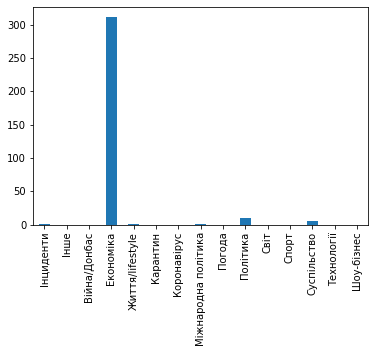

In [543]:
all_ments_df.loc['Борис Кушнірук'].category.plot(kind='bar')

### Check percentage of news with experts for every category

In [30]:
top_experts = '|'.join(all_ments_df[~all_ments_df.del_flag&(all_ments_df.num>50)].index.values)

In [35]:
top_categories

['Економіка', 'Коронавірус', 'Інциденти', 'Політика', 'Світ']

In [38]:
for cat in news.mycategory.value_counts().index:
    n = news[(news.mycategory==cat)&(news.found_names_str.str.contains(top_experts, na=False))].shape[0]
    print(cat, '\t', round(n/len(news[(news.mycategory==cat)])*100,2))

Інциденти 	 1.79
Політика 	 7.75
Коронавірус 	 5.07
Економіка 	 7.58
Шоу-бізнес 	 0.54
Світ 	 1.01
Спорт 	 0.26
Суспільство 	 3.18
Міжнародна політика 	 2.25
Життя/lifestyle 	 1.49
Технології 	 0.49
Війна/Донбас 	 2.55
Карантин 	 1.65
Погода 	 0.04
Інше 	 6.8


In [33]:
news[(news.mycategory=='Політика')&(news.found_names_str.str.contains(top_experts, na=False))].shape

(5925, 13)

In [43]:
news[(news.mycategory=='Економіка')&(news.found_names_str.str.contains(top_experts, na=False))].shape

(4495, 13)

In [ ]:
#### Add ids to experts profiles

# profiles = pd.read_csv('experts_profiles.csv', sep=';')
# profiles.image_name = profiles['name'].apply(get_image_name)

# for n in profiles.name.values:
#     profiles.loc[profiles['name']==n, 'expert_id'] = int(all_ments_df[all_ments_df.expert==n].expert_id.iloc[0])
    
# profiles['expert_id'] = profiles.expert_id.astype(int)

# profiles.to_csv('experts_profiles.csv', index=False, sep=';')